In [2]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.3 MB/s eta 0:00:00


In [3]:
!pip install wheel
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379449 sha256=098eebbc3f8261573aa1f28c80c927233d803f8e4640350a8f20d5abd44a8b2a
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


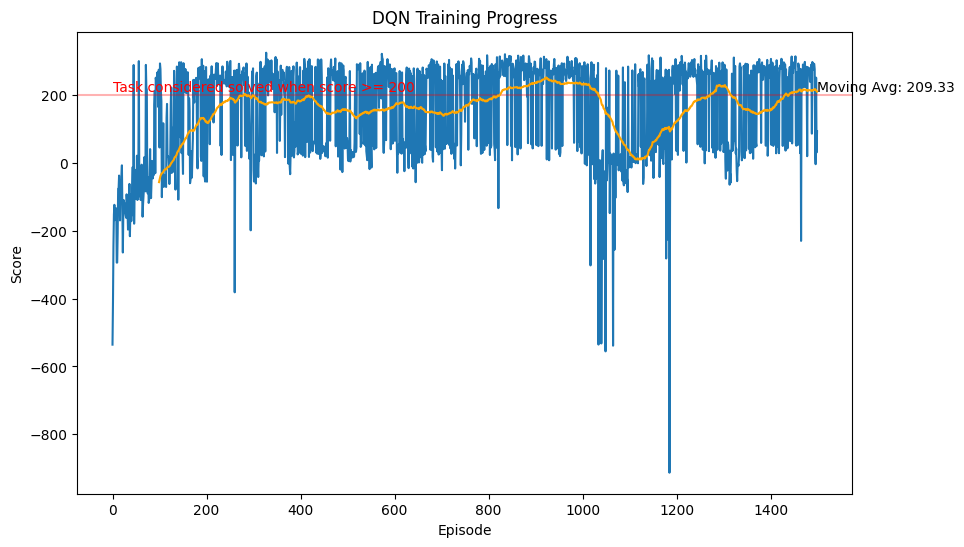

In [17]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the DQN model architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Define Replay Memory for experience replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return np.vstack(states), actions, rewards, np.vstack(next_states), dones

    def __len__(self):
        return len(self.memory)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Define hyperparameters
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory_size = 100000
        self.update_target_every = 100  # frequency to update target network

        # Create Q networks (policy and target)
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # target network is only used for inference

        # Define optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

        # Create replay memory
        self.memory = ReplayMemory(self.memory_size)

        # Initialize step counter (for target network updates)
        self.step_counter = 0

    def select_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action_values = self.policy_net(state)
        return torch.argmax(action_values).item()

    def learn(self):
        # Check if memory has enough samples
        if len(self.memory) < self.batch_size:
            return

        # Sample from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert to PyTorch tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # Get current Q values
        current_q_values = self.policy_net(states).gather(1, actions)

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute loss
        loss = F.smooth_l1_loss(current_q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to stabilize training
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        # Update epsilon (exploration rate)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.step_counter += 1
        if self.step_counter % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, filename="lunar_lander_dqn.pth"):
        torch.save(self.policy_net.state_dict(), filename)

    def load_model(self, filename="lunar_lander_dqn.pth"):
        self.policy_net.load_state_dict(torch.load(filename))
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Function to plot training progress
def plot_scores(scores, filename=None):
    clear_output(True)
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.title('DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    # Add a horizontal line at score 200 (considered "solved")
    plt.axhline(y=200, color='r', linestyle='-', alpha=0.3)
    plt.text(0, 210, 'Task considered solved when score >= 200', color='r')

    # Calculate and display moving average
    window_size = 100
    if len(scores) >= window_size:
        moving_avg = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(scores)), moving_avg, color='orange')
        plt.text(len(scores)-1, moving_avg[-1], f'Moving Avg: {moving_avg[-1]:.2f}')

    if filename:
        plt.savefig(filename)
    plt.show()

# Main training function
def train_lunar_lander(n_episodes=1500, max_steps=1000, target_score=200,
                       solve_threshold=100, render=False):
    # Create environment
    env = gym.make('LunarLander-v3')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create agent
    agent = DQNAgent(state_size, action_size)

    # Training variables
    scores = []
    avg_scores = []
    solved = False

    # Training loop
    for episode in range(n_episodes):
        state, _ = env.reset()
        score = 0

        for t in range(max_steps):
            # Select and perform an action
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store the transition in memory
            agent.memory.push(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization
            agent.learn()

            # Update score
            score += reward

            # Check if episode is done
            if done:
                break

        # Record score for this episode
        scores.append(score)

        # Calculate average score over last 100 episodes
        avg_score = np.mean(scores[-solve_threshold:]) if len(scores) >= solve_threshold else np.mean(scores)
        avg_scores.append(avg_score)
        print(f"Episode {episode}/{n_episodes}, Score: {score:.2f}, Avg Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.4f}")
        # Print progress
        if episode % 10 == 0:
            print(f"Episode {episode}/{n_episodes}, Score: {score:.2f}, Avg Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.4f}")
            # Plot progress
            if episode % 100 == 0:
                plot_scores(scores)

        # Check if environment is solved
        if len(scores) >= solve_threshold and avg_score >= target_score and not solved:
            print(f"\nEnvironment solved in {episode} episodes! Average Score: {avg_score:.2f}")
            # Save the model
            agent.save_model()
            solved = True

    # Close environment
    env.close()

    # Plot final scores
    plot_scores(scores, "dqn_lunar_lander_training.png")

    return agent, scores

# Function to evaluate and visualize a trained agent
def evaluate_agent(agent, n_episodes=5, render=True):
    # Create environment
    env = gym.make('LunarLander-v3', render_mode='human' if render else None)

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Select action with trained policy (no exploration)
            agent.epsilon = 0  # Turn off exploration
            action = agent.select_action(state)

            # Take action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_reward += reward

            if render:
                env.render()

        print(f"Episode {episode+1}/{n_episodes}, Total Reward: {total_reward:.2f}")

    env.close()

if __name__ == "__main__":
    #Train agent
    print("Starting training...")
    agent, scores = train_lunar_lander(n_episodes=1500)
    env = gym.make('LunarLander-v3')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    # Evaluate trained agent
    # print("\nEvaluating trained agent...")
    # agent = DQNAgent(state_size, action_size)
    # agent.load_model("lunar_lander_dqn.pth")
    # evaluate_agent(agent, n_episodes=5)

In [6]:
import os
if os.path.exists("lunar_lander_dqn.pth"):
    agent.load_model("lunar_lander_dqn.pth")
else:
    print("Model file not found! Train the model first.")


Model file not found! Train the model first.


In [10]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the DQN model architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Define Replay Memory for experience replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return np.vstack(states), actions, rewards, np.vstack(next_states), dones

    def __len__(self):
        return len(self.memory)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Define hyperparameters
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory_size = 100000
        self.update_target_every = 100  # frequency to update target network

        # Create Q networks (policy and target)
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # target network is only used for inference

        # Define optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

        # Create replay memory
        self.memory = ReplayMemory(self.memory_size)

        # Initialize step counter (for target network updates)
        self.step_counter = 0

    def select_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action_values = self.policy_net(state)
        return torch.argmax(action_values).item()

    def learn(self):
        # Check if memory has enough samples
        if len(self.memory) < self.batch_size:
            return

        # Sample from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert to PyTorch tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # Get current Q values
        current_q_values = self.policy_net(states).gather(1, actions)

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute loss
        loss = F.smooth_l1_loss(current_q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to stabilize training
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        # Update epsilon (exploration rate)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.step_counter += 1
        if self.step_counter % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, filename="lunar_lander_dqn.pth"):
        torch.save(self.policy_net.state_dict(), filename)

    def load_model(self, filename="lunar_lander_dqn.pth"):
        self.policy_net.load_state_dict(torch.load(filename))
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Function to plot training progress
def plot_scores(scores, filename=None):
    clear_output(True)
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.title('DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    # Add a horizontal line at score 200 (considered "solved")
    plt.axhline(y=200, color='r', linestyle='-', alpha=0.3)
    plt.text(0, 210, 'Task considered solved when score >= 200', color='r')

    # Calculate and display moving average
    window_size = 100
    if len(scores) >= window_size:
        moving_avg = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(scores)), moving_avg, color='orange')
        plt.text(len(scores)-1, moving_avg[-1], f'Moving Avg: {moving_avg[-1]:.2f}')

    if filename:
        plt.savefig(filename)
    plt.show()

# Main training function
def train_lunar_lander(n_episodes=1500, max_steps=1000, target_score=200,
                       solve_threshold=100, render=False):
    # Create environment
    env = gym.make('LunarLander-v3')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create agent
    agent = DQNAgent(state_size, action_size)

    # Training variables
    scores = []
    avg_scores = []
    solved = False

    # Training loop
    for episode in range(n_episodes):
        state, _ = env.reset()
        score = 0

        for t in range(max_steps):
            # Select and perform an action
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store the transition in memory
            agent.memory.push(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization
            agent.learn()

            # Update score
            score += reward

            # Check if episode is done
            if done:
                break

        # Record score for this episode
        scores.append(score)

        # Calculate average score over last 100 episodes
        avg_score = np.mean(scores[-solve_threshold:]) if len(scores) >= solve_threshold else np.mean(scores)
        avg_scores.append(avg_score)
        print(f"Episode {episode}/{n_episodes}, Score: {score:.2f}, Avg Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.4f}")
        # Print progress
        if episode % 10 == 0:
            print(f"Episode {episode}/{n_episodes}, Score: {score:.2f}, Avg Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.4f}")
            # Plot progress
            if episode % 100 == 0:
                plot_scores(scores)

        # Check if environment is solved
        if len(scores) >= solve_threshold and avg_score >= target_score and not solved:
            print(f"\nEnvironment solved in {episode} episodes! Average Score: {avg_score:.2f}")
            # Save the model
            agent.save_model()
            solved = True

    # Close environment
    env.close()

    # Plot final scores
    plot_scores(scores, "dqn_lunar_lander_training.png")

    return agent, scores

# Function to evaluate and visualize a trained agent
def evaluate_agent(agent, n_episodes=5, render=True):
    # Create environment
    env = gym.make('LunarLander-v3', render_mode='human' if render else None)

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Select action with trained policy (no exploration)
            agent.epsilon = 0  # Turn off exploration
            action = agent.select_action(state)

            # Take action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_reward += reward

            if render:
                env.render()

        print(f"Episode {episode+1}/{n_episodes}, Total Reward: {total_reward:.2f}")

    env.close()


Mounted at /content/drive
Starting training...
Episode 0/1500, Score: -85.28, Epsilon: 0.9183
Training progress saved to /content/drive/MyDrive/DQN_LunarLander/dqn_lunar_lander_training.png


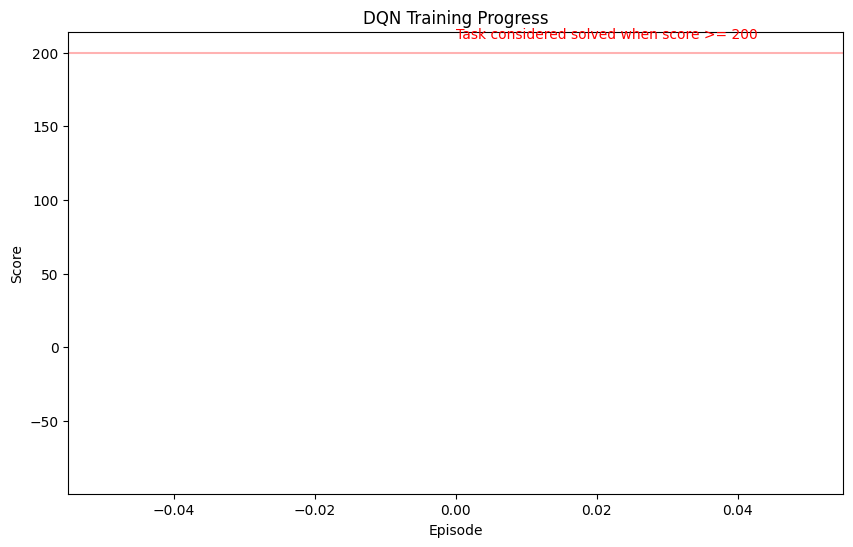

Episode 1/1500, Score: -209.12, Epsilon: 0.4644
Episode 2/1500, Score: -314.50, Epsilon: 0.2636
Episode 3/1500, Score: -195.93, Epsilon: 0.0250
Episode 4/1500, Score: -65.20, Epsilon: 0.0100
Episode 5/1500, Score: -127.35, Epsilon: 0.0100
Episode 6/1500, Score: -101.89, Epsilon: 0.0100
Episode 7/1500, Score: -76.59, Epsilon: 0.0100
Episode 8/1500, Score: -109.86, Epsilon: 0.0100
Episode 9/1500, Score: 9.53, Epsilon: 0.0100
Episode 10/1500, Score: -17.39, Epsilon: 0.0100
Episode 11/1500, Score: -74.58, Epsilon: 0.0100
Episode 12/1500, Score: 7.72, Epsilon: 0.0100
Episode 13/1500, Score: -61.08, Epsilon: 0.0100
Episode 14/1500, Score: -5.36, Epsilon: 0.0100
Episode 15/1500, Score: -39.41, Epsilon: 0.0100
Episode 16/1500, Score: -29.16, Epsilon: 0.0100
Episode 17/1500, Score: -53.34, Epsilon: 0.0100
Episode 18/1500, Score: -35.77, Epsilon: 0.0100
Episode 19/1500, Score: -69.93, Epsilon: 0.0100
Episode 20/1500, Score: -20.11, Epsilon: 0.0100
Episode 21/1500, Score: -250.34, Epsilon: 0.0100

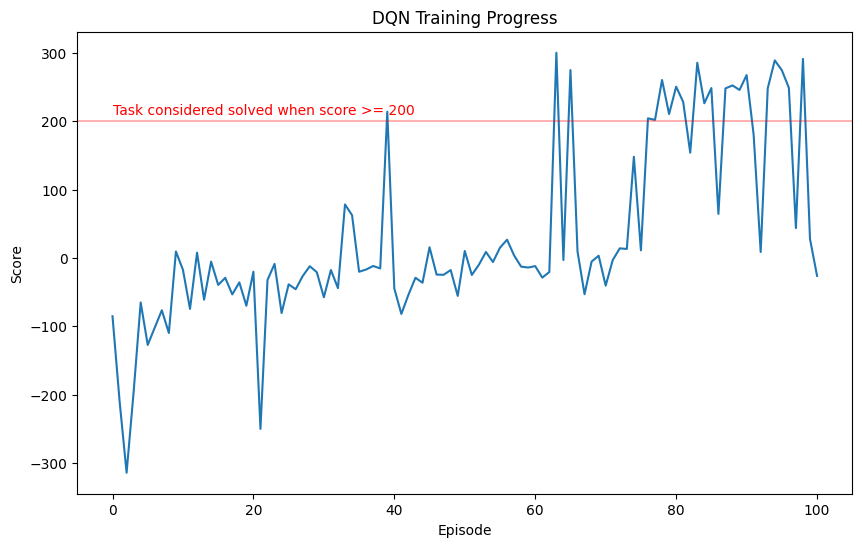

Episode 101/1500, Score: 229.08, Epsilon: 0.0100
Episode 102/1500, Score: 253.43, Epsilon: 0.0100
Episode 103/1500, Score: 257.26, Epsilon: 0.0100
Episode 104/1500, Score: 264.39, Epsilon: 0.0100
Episode 105/1500, Score: 272.09, Epsilon: 0.0100
Episode 106/1500, Score: 282.17, Epsilon: 0.0100
Episode 107/1500, Score: 25.14, Epsilon: 0.0100
Episode 108/1500, Score: 250.22, Epsilon: 0.0100
Episode 109/1500, Score: 261.67, Epsilon: 0.0100
Episode 110/1500, Score: 239.38, Epsilon: 0.0100
Episode 111/1500, Score: 230.11, Epsilon: 0.0100
Episode 112/1500, Score: 263.91, Epsilon: 0.0100
Episode 113/1500, Score: 275.37, Epsilon: 0.0100
Episode 114/1500, Score: 281.49, Epsilon: 0.0100
Episode 115/1500, Score: 232.55, Epsilon: 0.0100
Episode 116/1500, Score: 272.61, Epsilon: 0.0100
Episode 117/1500, Score: 282.35, Epsilon: 0.0100
Episode 118/1500, Score: 269.85, Epsilon: 0.0100
Episode 119/1500, Score: 219.76, Epsilon: 0.0100
Episode 120/1500, Score: 236.33, Epsilon: 0.0100
Episode 121/1500, Sco

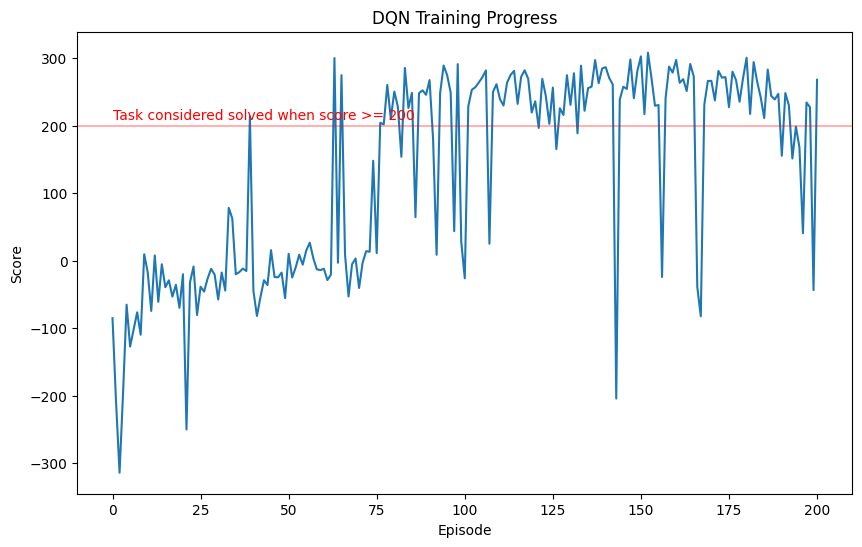

Episode 201/1500, Score: 297.38, Epsilon: 0.0100
Episode 202/1500, Score: 293.64, Epsilon: 0.0100
Episode 203/1500, Score: 238.25, Epsilon: 0.0100
Episode 204/1500, Score: 237.07, Epsilon: 0.0100
Episode 205/1500, Score: 269.46, Epsilon: 0.0100
Episode 206/1500, Score: 293.96, Epsilon: 0.0100
Episode 207/1500, Score: 25.67, Epsilon: 0.0100
Episode 208/1500, Score: 285.23, Epsilon: 0.0100
Episode 209/1500, Score: 39.99, Epsilon: 0.0100
Episode 210/1500, Score: 246.43, Epsilon: 0.0100
Episode 211/1500, Score: 255.60, Epsilon: 0.0100
Episode 212/1500, Score: 275.61, Epsilon: 0.0100
Episode 213/1500, Score: 222.54, Epsilon: 0.0100
Episode 214/1500, Score: 252.09, Epsilon: 0.0100
Episode 215/1500, Score: 273.00, Epsilon: 0.0100
Episode 216/1500, Score: 302.91, Epsilon: 0.0100
Episode 217/1500, Score: 201.88, Epsilon: 0.0100
Episode 218/1500, Score: -5.16, Epsilon: 0.0100
Episode 219/1500, Score: 68.59, Epsilon: 0.0100
Episode 220/1500, Score: 205.62, Epsilon: 0.0100
Episode 221/1500, Score:

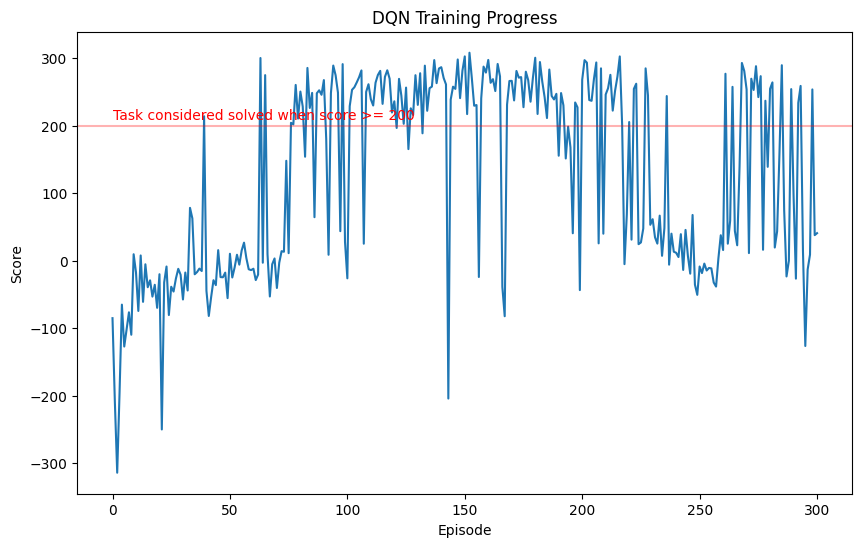

Episode 301/1500, Score: 268.03, Epsilon: 0.0100
Episode 302/1500, Score: 265.62, Epsilon: 0.0100
Episode 303/1500, Score: 292.06, Epsilon: 0.0100
Episode 304/1500, Score: 244.78, Epsilon: 0.0100
Episode 305/1500, Score: 20.71, Epsilon: 0.0100
Episode 306/1500, Score: 24.11, Epsilon: 0.0100
Episode 307/1500, Score: 287.36, Epsilon: 0.0100
Episode 308/1500, Score: -24.72, Epsilon: 0.0100
Episode 309/1500, Score: 267.25, Epsilon: 0.0100
Episode 310/1500, Score: 44.59, Epsilon: 0.0100
Episode 311/1500, Score: -2.81, Epsilon: 0.0100
Episode 312/1500, Score: 289.84, Epsilon: 0.0100
Episode 313/1500, Score: 5.25, Epsilon: 0.0100
Episode 314/1500, Score: 278.49, Epsilon: 0.0100
Episode 315/1500, Score: 234.75, Epsilon: 0.0100
Episode 316/1500, Score: 282.11, Epsilon: 0.0100
Episode 317/1500, Score: 66.64, Epsilon: 0.0100
Episode 318/1500, Score: 250.87, Epsilon: 0.0100
Episode 319/1500, Score: 282.99, Epsilon: 0.0100
Episode 320/1500, Score: 126.29, Epsilon: 0.0100
Episode 321/1500, Score: 26

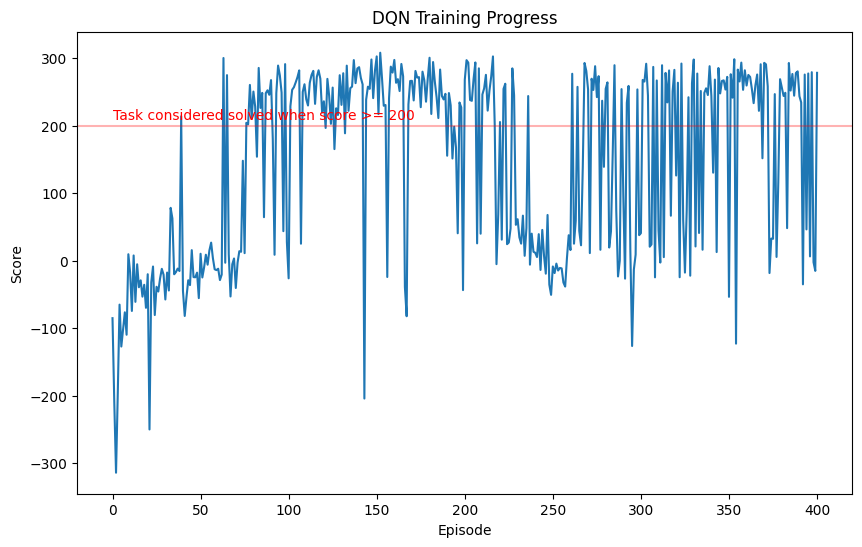

Episode 401/1500, Score: 272.47, Epsilon: 0.0100
Episode 402/1500, Score: -24.04, Epsilon: 0.0100
Episode 403/1500, Score: 31.16, Epsilon: 0.0100
Episode 404/1500, Score: 240.46, Epsilon: 0.0100
Episode 405/1500, Score: 256.09, Epsilon: 0.0100
Episode 406/1500, Score: 31.63, Epsilon: 0.0100
Episode 407/1500, Score: 267.45, Epsilon: 0.0100
Episode 408/1500, Score: 0.32, Epsilon: 0.0100
Episode 409/1500, Score: 13.60, Epsilon: 0.0100
Episode 410/1500, Score: 27.71, Epsilon: 0.0100
Episode 411/1500, Score: -23.34, Epsilon: 0.0100
Episode 412/1500, Score: 4.05, Epsilon: 0.0100
Episode 413/1500, Score: 261.47, Epsilon: 0.0100
Episode 414/1500, Score: 69.33, Epsilon: 0.0100
Episode 415/1500, Score: 309.87, Epsilon: 0.0100
Episode 416/1500, Score: 263.85, Epsilon: 0.0100
Episode 417/1500, Score: -30.90, Epsilon: 0.0100
Episode 418/1500, Score: 42.07, Epsilon: 0.0100
Episode 419/1500, Score: 32.67, Epsilon: 0.0100
Episode 420/1500, Score: 1.11, Epsilon: 0.0100
Episode 421/1500, Score: 2.93, Ep

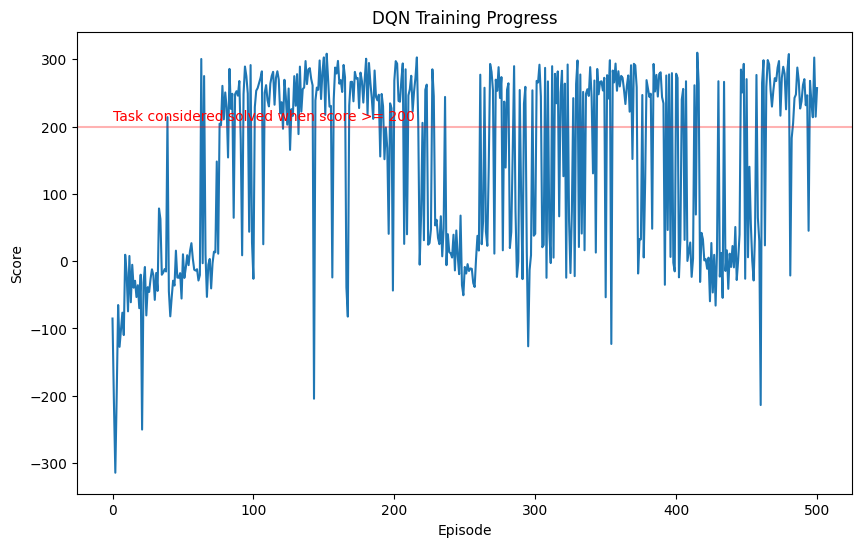

Episode 501/1500, Score: 306.87, Epsilon: 0.0100
Episode 502/1500, Score: 235.87, Epsilon: 0.0100
Episode 503/1500, Score: 295.90, Epsilon: 0.0100
Episode 504/1500, Score: 224.06, Epsilon: 0.0100
Episode 505/1500, Score: 268.05, Epsilon: 0.0100
Episode 506/1500, Score: 213.11, Epsilon: 0.0100
Episode 507/1500, Score: 267.28, Epsilon: 0.0100
Episode 508/1500, Score: 273.49, Epsilon: 0.0100
Episode 509/1500, Score: 250.87, Epsilon: 0.0100
Episode 510/1500, Score: 258.61, Epsilon: 0.0100
Episode 511/1500, Score: 300.91, Epsilon: 0.0100
Episode 512/1500, Score: 283.65, Epsilon: 0.0100
Episode 513/1500, Score: 209.27, Epsilon: 0.0100
Episode 514/1500, Score: 294.07, Epsilon: 0.0100
Episode 515/1500, Score: 250.09, Epsilon: 0.0100
Episode 516/1500, Score: 96.52, Epsilon: 0.0100
Episode 517/1500, Score: 268.42, Epsilon: 0.0100
Episode 518/1500, Score: 271.92, Epsilon: 0.0100
Episode 519/1500, Score: 263.61, Epsilon: 0.0100
Episode 520/1500, Score: 279.67, Epsilon: 0.0100
Episode 521/1500, Sco

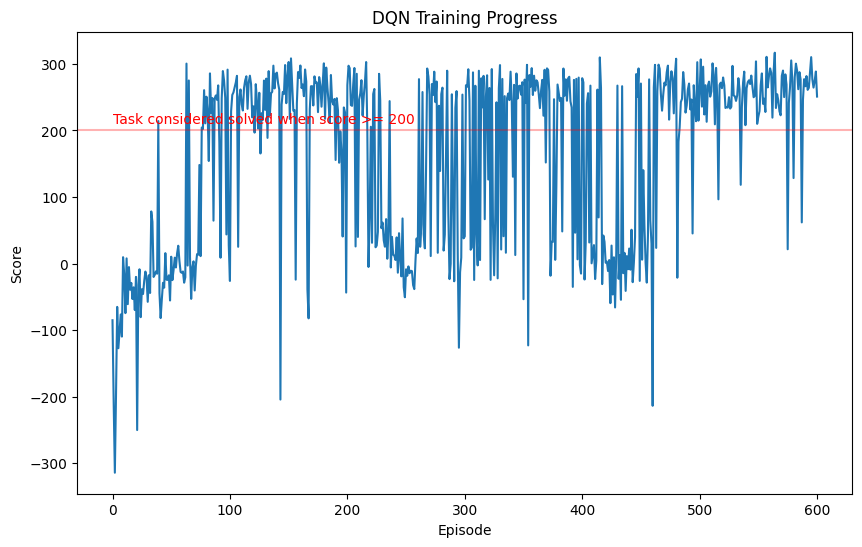

Episode 601/1500, Score: 51.39, Epsilon: 0.0100
Episode 602/1500, Score: 291.57, Epsilon: 0.0100
Episode 603/1500, Score: 256.33, Epsilon: 0.0100
Episode 604/1500, Score: 280.79, Epsilon: 0.0100
Episode 605/1500, Score: 277.10, Epsilon: 0.0100
Episode 606/1500, Score: 290.21, Epsilon: 0.0100
Episode 607/1500, Score: 272.12, Epsilon: 0.0100
Episode 608/1500, Score: 294.23, Epsilon: 0.0100
Episode 609/1500, Score: 268.36, Epsilon: 0.0100
Episode 610/1500, Score: 308.12, Epsilon: 0.0100
Episode 611/1500, Score: 295.26, Epsilon: 0.0100
Episode 612/1500, Score: 289.01, Epsilon: 0.0100
Episode 613/1500, Score: 292.40, Epsilon: 0.0100
Episode 614/1500, Score: 313.41, Epsilon: 0.0100
Episode 615/1500, Score: 250.63, Epsilon: 0.0100
Episode 616/1500, Score: 282.35, Epsilon: 0.0100
Episode 617/1500, Score: 291.34, Epsilon: 0.0100
Episode 618/1500, Score: 256.29, Epsilon: 0.0100
Episode 619/1500, Score: 261.02, Epsilon: 0.0100
Episode 620/1500, Score: 289.18, Epsilon: 0.0100
Episode 621/1500, Sco

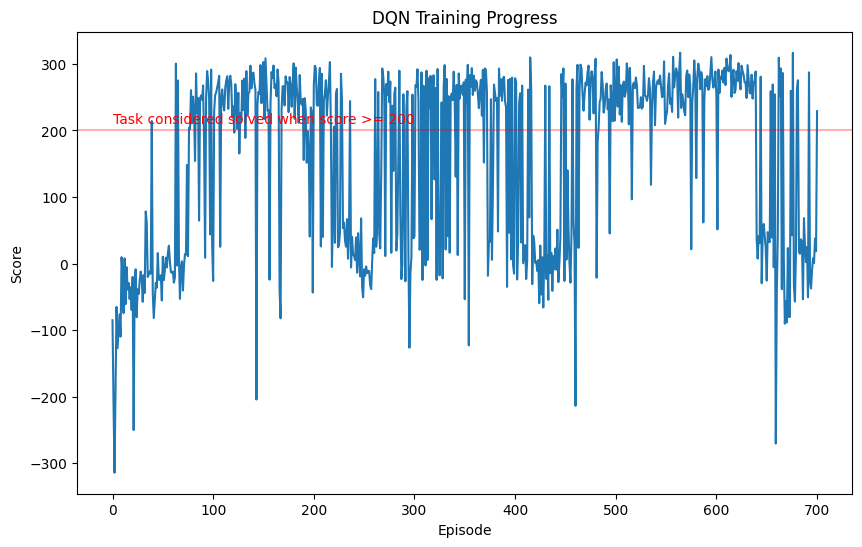

Episode 701/1500, Score: -46.03, Epsilon: 0.0100
Episode 702/1500, Score: -33.23, Epsilon: 0.0100
Episode 703/1500, Score: -24.81, Epsilon: 0.0100
Episode 704/1500, Score: -98.80, Epsilon: 0.0100
Episode 705/1500, Score: -1.00, Epsilon: 0.0100
Episode 706/1500, Score: -56.93, Epsilon: 0.0100
Episode 707/1500, Score: -110.05, Epsilon: 0.0100
Episode 708/1500, Score: 4.88, Epsilon: 0.0100
Episode 709/1500, Score: 252.42, Epsilon: 0.0100
Episode 710/1500, Score: 6.11, Epsilon: 0.0100
Episode 711/1500, Score: 249.19, Epsilon: 0.0100
Episode 712/1500, Score: 3.05, Epsilon: 0.0100
Episode 713/1500, Score: 56.83, Epsilon: 0.0100
Episode 714/1500, Score: 7.19, Epsilon: 0.0100
Episode 715/1500, Score: 28.91, Epsilon: 0.0100
Episode 716/1500, Score: 38.62, Epsilon: 0.0100
Episode 717/1500, Score: 17.69, Epsilon: 0.0100
Episode 718/1500, Score: 42.07, Epsilon: 0.0100
Episode 719/1500, Score: -16.97, Epsilon: 0.0100
Episode 720/1500, Score: 29.19, Epsilon: 0.0100
Episode 721/1500, Score: 30.29, Ep

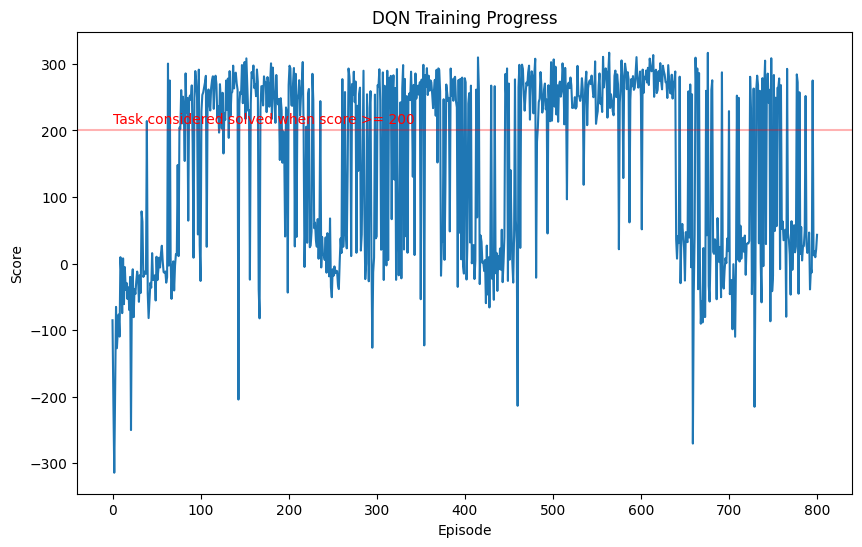

Episode 801/1500, Score: 212.05, Epsilon: 0.0100
Episode 802/1500, Score: 35.84, Epsilon: 0.0100
Episode 803/1500, Score: 293.25, Epsilon: 0.0100
Episode 804/1500, Score: 39.16, Epsilon: 0.0100
Episode 805/1500, Score: 5.97, Epsilon: 0.0100
Episode 806/1500, Score: 31.62, Epsilon: 0.0100
Episode 807/1500, Score: 308.32, Epsilon: 0.0100
Episode 808/1500, Score: 295.49, Epsilon: 0.0100
Episode 809/1500, Score: 14.72, Epsilon: 0.0100
Episode 810/1500, Score: 274.81, Epsilon: 0.0100
Episode 811/1500, Score: -11.06, Epsilon: 0.0100
Episode 812/1500, Score: -12.51, Epsilon: 0.0100
Episode 813/1500, Score: 21.75, Epsilon: 0.0100
Episode 814/1500, Score: -25.11, Epsilon: 0.0100
Episode 815/1500, Score: 17.49, Epsilon: 0.0100
Episode 816/1500, Score: -51.79, Epsilon: 0.0100
Episode 817/1500, Score: 301.52, Epsilon: 0.0100
Episode 818/1500, Score: 16.68, Epsilon: 0.0100
Episode 819/1500, Score: -150.86, Epsilon: 0.0100
Episode 820/1500, Score: 124.08, Epsilon: 0.0100
Episode 821/1500, Score: 7.3

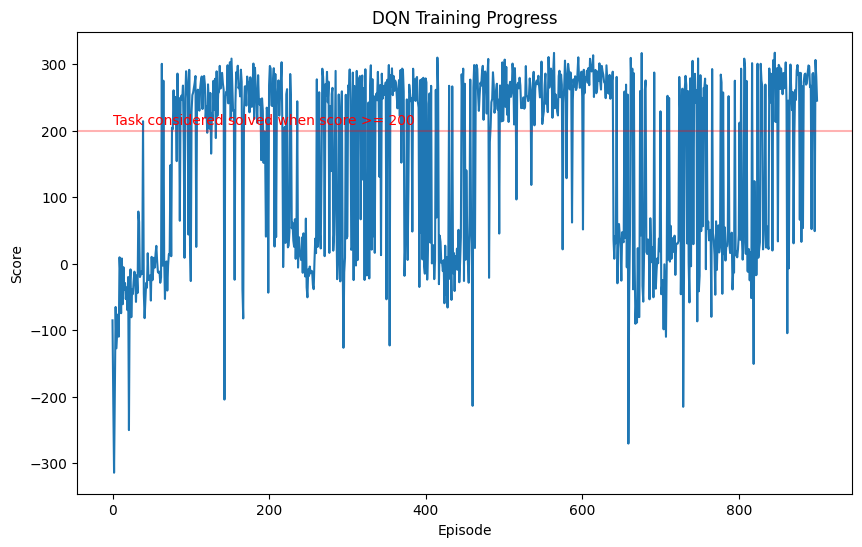

Episode 901/1500, Score: 224.58, Epsilon: 0.0100
Episode 902/1500, Score: 263.58, Epsilon: 0.0100
Episode 903/1500, Score: 264.88, Epsilon: 0.0100
Episode 904/1500, Score: 245.88, Epsilon: 0.0100
Episode 905/1500, Score: 240.77, Epsilon: 0.0100
Episode 906/1500, Score: 261.57, Epsilon: 0.0100
Episode 907/1500, Score: 309.00, Epsilon: 0.0100
Episode 908/1500, Score: 244.61, Epsilon: 0.0100
Episode 909/1500, Score: 288.32, Epsilon: 0.0100
Episode 910/1500, Score: 254.74, Epsilon: 0.0100
Episode 911/1500, Score: 243.13, Epsilon: 0.0100
Episode 912/1500, Score: 276.25, Epsilon: 0.0100
Episode 913/1500, Score: 287.78, Epsilon: 0.0100
Episode 914/1500, Score: 297.16, Epsilon: 0.0100
Episode 915/1500, Score: 266.32, Epsilon: 0.0100
Episode 916/1500, Score: 289.86, Epsilon: 0.0100
Episode 917/1500, Score: 267.34, Epsilon: 0.0100
Episode 918/1500, Score: 83.75, Epsilon: 0.0100
Episode 919/1500, Score: 295.27, Epsilon: 0.0100
Episode 920/1500, Score: 270.31, Epsilon: 0.0100
Episode 921/1500, Sco

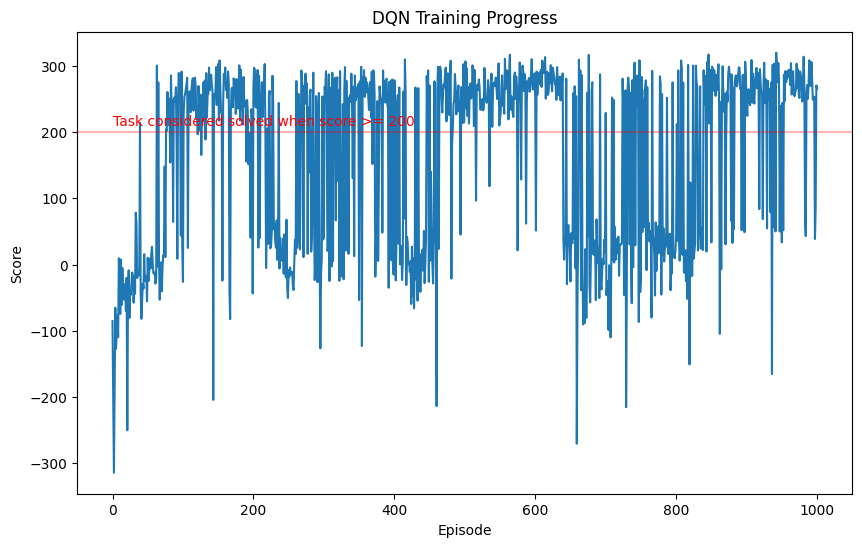

Episode 1001/1500, Score: 324.93, Epsilon: 0.0100
Episode 1002/1500, Score: 260.84, Epsilon: 0.0100
Episode 1003/1500, Score: 66.71, Epsilon: 0.0100
Episode 1004/1500, Score: 283.88, Epsilon: 0.0100
Episode 1005/1500, Score: 277.19, Epsilon: 0.0100
Episode 1006/1500, Score: 291.52, Epsilon: 0.0100
Episode 1007/1500, Score: 255.29, Epsilon: 0.0100
Episode 1008/1500, Score: 40.96, Epsilon: 0.0100
Episode 1009/1500, Score: 302.46, Epsilon: 0.0100
Episode 1010/1500, Score: 21.15, Epsilon: 0.0100
Episode 1011/1500, Score: 258.81, Epsilon: 0.0100
Episode 1012/1500, Score: 254.37, Epsilon: 0.0100
Episode 1013/1500, Score: 81.66, Epsilon: 0.0100
Episode 1014/1500, Score: 241.47, Epsilon: 0.0100
Episode 1015/1500, Score: 261.93, Epsilon: 0.0100
Episode 1016/1500, Score: 264.05, Epsilon: 0.0100
Episode 1017/1500, Score: 271.59, Epsilon: 0.0100
Episode 1018/1500, Score: 255.52, Epsilon: 0.0100
Episode 1019/1500, Score: 290.50, Epsilon: 0.0100
Episode 1020/1500, Score: 278.52, Epsilon: 0.0100
Epis

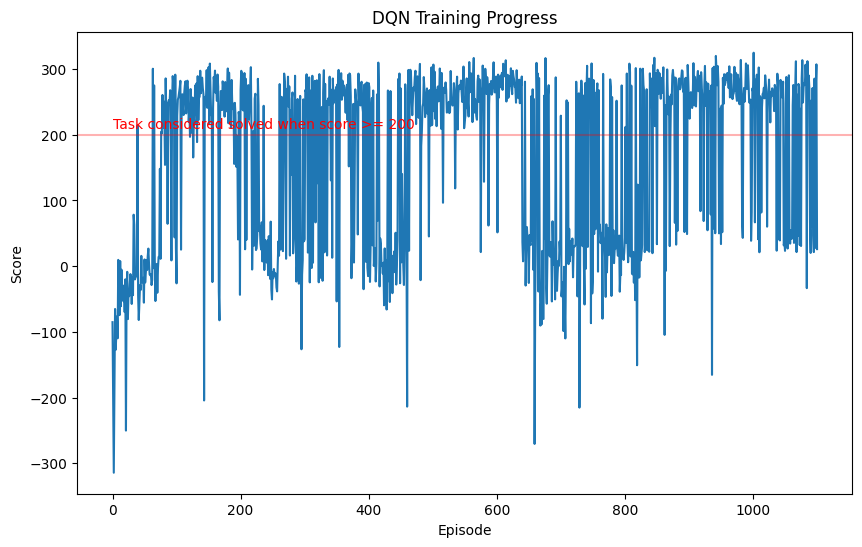

Episode 1101/1500, Score: 308.59, Epsilon: 0.0100
Episode 1102/1500, Score: 287.75, Epsilon: 0.0100
Episode 1103/1500, Score: 284.72, Epsilon: 0.0100
Episode 1104/1500, Score: 47.61, Epsilon: 0.0100
Episode 1105/1500, Score: 49.54, Epsilon: 0.0100
Episode 1106/1500, Score: 292.82, Epsilon: 0.0100
Episode 1107/1500, Score: 266.84, Epsilon: 0.0100
Episode 1108/1500, Score: 283.76, Epsilon: 0.0100
Episode 1109/1500, Score: 288.31, Epsilon: 0.0100
Episode 1110/1500, Score: 29.15, Epsilon: 0.0100
Episode 1111/1500, Score: 24.79, Epsilon: 0.0100
Episode 1112/1500, Score: 282.66, Epsilon: 0.0100
Episode 1113/1500, Score: 281.25, Epsilon: 0.0100
Episode 1114/1500, Score: 286.78, Epsilon: 0.0100
Episode 1115/1500, Score: 45.01, Epsilon: 0.0100
Episode 1116/1500, Score: 30.35, Epsilon: 0.0100
Episode 1117/1500, Score: 19.59, Epsilon: 0.0100
Episode 1118/1500, Score: 287.78, Epsilon: 0.0100
Episode 1119/1500, Score: 76.11, Epsilon: 0.0100
Episode 1120/1500, Score: 252.71, Epsilon: 0.0100
Episode 

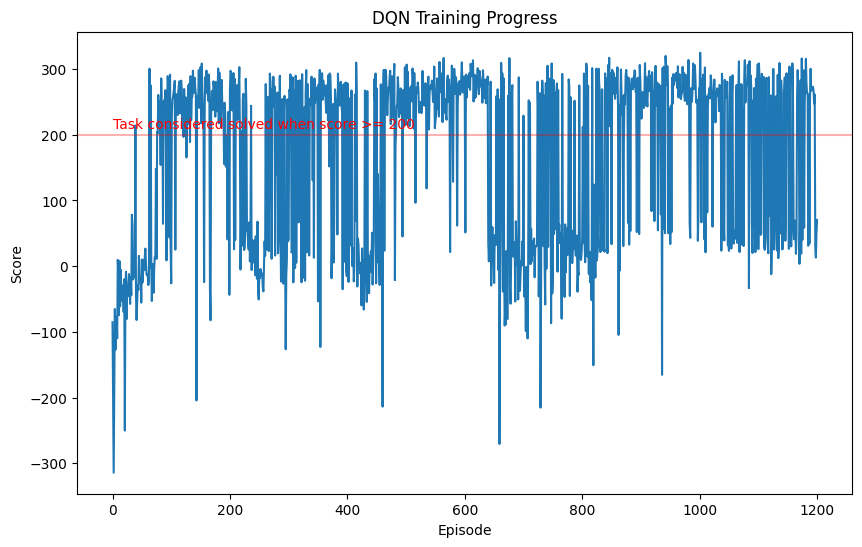

Episode 1201/1500, Score: 11.11, Epsilon: 0.0100
Episode 1202/1500, Score: 11.22, Epsilon: 0.0100
Episode 1203/1500, Score: 302.94, Epsilon: 0.0100
Episode 1204/1500, Score: 57.09, Epsilon: 0.0100
Episode 1205/1500, Score: 21.93, Epsilon: 0.0100
Episode 1206/1500, Score: 247.10, Epsilon: 0.0100
Episode 1207/1500, Score: 57.37, Epsilon: 0.0100
Episode 1208/1500, Score: 245.52, Epsilon: 0.0100
Episode 1209/1500, Score: 47.82, Epsilon: 0.0100
Episode 1210/1500, Score: 24.41, Epsilon: 0.0100
Episode 1211/1500, Score: 8.34, Epsilon: 0.0100
Episode 1212/1500, Score: -20.19, Epsilon: 0.0100
Episode 1213/1500, Score: 25.18, Epsilon: 0.0100
Episode 1214/1500, Score: 273.13, Epsilon: 0.0100
Episode 1215/1500, Score: 241.20, Epsilon: 0.0100
Episode 1216/1500, Score: 294.15, Epsilon: 0.0100
Episode 1217/1500, Score: 221.65, Epsilon: 0.0100
Episode 1218/1500, Score: 17.43, Epsilon: 0.0100
Episode 1219/1500, Score: 263.03, Epsilon: 0.0100
Episode 1220/1500, Score: 291.93, Epsilon: 0.0100
Episode 122

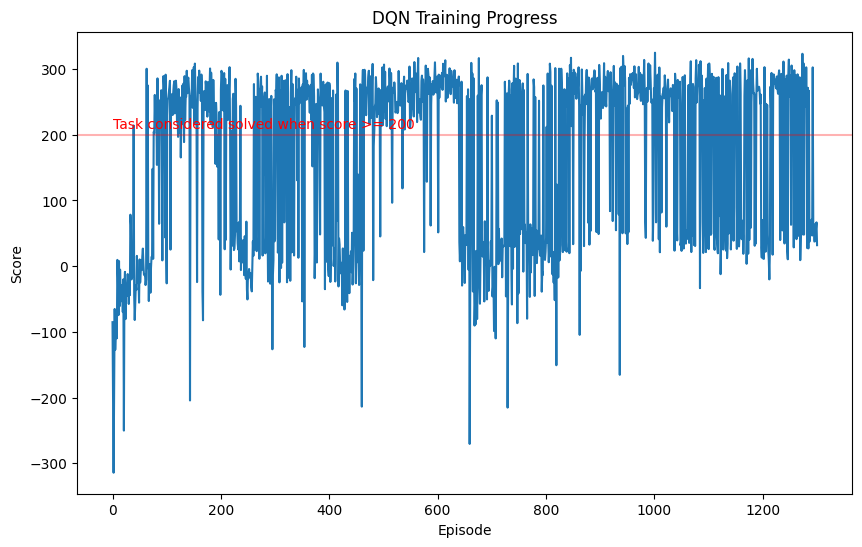

Episode 1301/1500, Score: 28.12, Epsilon: 0.0100
Episode 1302/1500, Score: 249.28, Epsilon: 0.0100
Episode 1303/1500, Score: 263.36, Epsilon: 0.0100
Episode 1304/1500, Score: -154.29, Epsilon: 0.0100
Episode 1305/1500, Score: 296.71, Epsilon: 0.0100
Episode 1306/1500, Score: 35.35, Epsilon: 0.0100
Episode 1307/1500, Score: 302.21, Epsilon: 0.0100
Episode 1308/1500, Score: 288.86, Epsilon: 0.0100
Episode 1309/1500, Score: 42.75, Epsilon: 0.0100
Episode 1310/1500, Score: 305.90, Epsilon: 0.0100
Episode 1311/1500, Score: 263.53, Epsilon: 0.0100
Episode 1312/1500, Score: 46.22, Epsilon: 0.0100
Episode 1313/1500, Score: 264.82, Epsilon: 0.0100
Episode 1314/1500, Score: 276.31, Epsilon: 0.0100
Episode 1315/1500, Score: 278.54, Epsilon: 0.0100
Episode 1316/1500, Score: 278.65, Epsilon: 0.0100
Episode 1317/1500, Score: 284.40, Epsilon: 0.0100
Episode 1318/1500, Score: 70.13, Epsilon: 0.0100
Episode 1319/1500, Score: 60.24, Epsilon: 0.0100
Episode 1320/1500, Score: 209.75, Epsilon: 0.0100
Episo

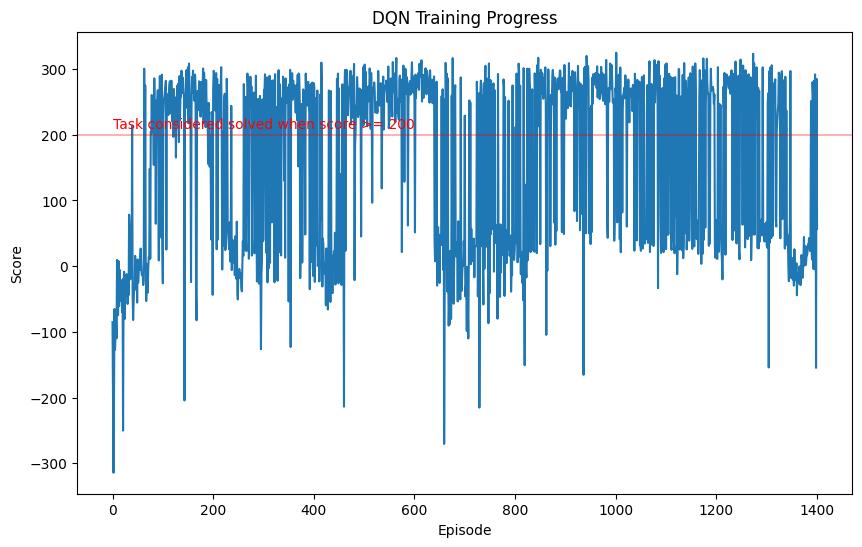

Episode 1401/1500, Score: 254.47, Epsilon: 0.0100
Episode 1402/1500, Score: 244.45, Epsilon: 0.0100
Episode 1403/1500, Score: 259.91, Epsilon: 0.0100
Episode 1404/1500, Score: 257.27, Epsilon: 0.0100
Episode 1405/1500, Score: 271.51, Epsilon: 0.0100
Episode 1406/1500, Score: 22.61, Epsilon: 0.0100
Episode 1407/1500, Score: 297.92, Epsilon: 0.0100
Episode 1408/1500, Score: 315.32, Epsilon: 0.0100
Episode 1409/1500, Score: 267.49, Epsilon: 0.0100
Episode 1410/1500, Score: 307.56, Epsilon: 0.0100
Episode 1411/1500, Score: 22.49, Epsilon: 0.0100
Episode 1412/1500, Score: 230.84, Epsilon: 0.0100
Episode 1413/1500, Score: 244.26, Epsilon: 0.0100
Episode 1414/1500, Score: 190.54, Epsilon: 0.0100
Episode 1415/1500, Score: 302.90, Epsilon: 0.0100
Episode 1416/1500, Score: 245.19, Epsilon: 0.0100
Episode 1417/1500, Score: 7.73, Epsilon: 0.0100
Episode 1418/1500, Score: 177.65, Epsilon: 0.0100
Episode 1419/1500, Score: 213.72, Epsilon: 0.0100
Episode 1420/1500, Score: 205.32, Epsilon: 0.0100
Epis

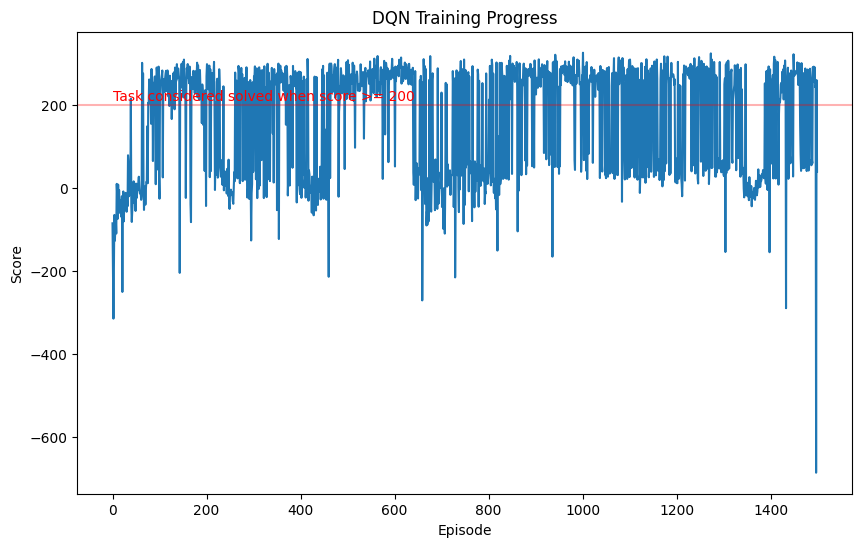

In [12]:
import os
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
from google.colab import drive

drive.mount('/content/drive')  # Mount Google Drive
save_dir = "/content/drive/MyDrive/DQN_LunarLander"
os.makedirs(save_dir, exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return np.vstack(states), actions, rewards, np.vstack(next_states), dones

    def __len__(self):
        return len(self.memory)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory_size = 100000
        self.update_target_every = 100  # Target network update frequency

        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(self.memory_size)
        self.step_counter = 0

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action_values = self.policy_net(state)
        return torch.argmax(action_values).item()

    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        current_q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = F.smooth_l1_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.step_counter += 1
        if self.step_counter % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, filename="lunar_lander_dqn.pth"):
        filepath = os.path.join(save_dir, filename)
        torch.save(self.policy_net.state_dict(), filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filename="lunar_lander_dqn.pth"):
        filepath = os.path.join(save_dir, filename)
        self.policy_net.load_state_dict(torch.load(filepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Plot Training Progress
def plot_scores(scores):
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.title('DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    plt.axhline(y=200, color='r', linestyle='-', alpha=0.3)
    plt.text(0, 210, 'Task considered solved when score >= 200', color='r')

    filepath = os.path.join(save_dir, "dqn_lunar_lander_training.png")
    plt.savefig(filepath)
    print(f"Training progress saved to {filepath}")
    plt.show()

# Train Function
def train_lunar_lander(n_episodes=1500):
    env = gym.make('LunarLander-v3')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    scores = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        score = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            agent.learn()
            score += reward

        scores.append(score)
        print(f"Episode {episode}/{n_episodes}, Score: {score:.2f}, Epsilon: {agent.epsilon:.4f}")

        if episode % 100 == 0:
            plot_scores(scores)

    agent.save_model()
    plot_scores(scores)
    env.close()
    return agent

if __name__ == "__main__":
    print("Starting training...")
    agent = train_lunar_lander()


In [18]:
agent = DQNAgent(state_size, action_size)
agent.load_model('/content/lunar_lander_dqn.pth')  # Adjust path if needed


In [19]:
evaluate_agent(agent, n_episodes=5, render=True)


Episode 1/5, Total Reward: 42.31
Episode 2/5, Total Reward: 248.93
Episode 3/5, Total Reward: 39.15
Episode 4/5, Total Reward: 173.50
Episode 5/5, Total Reward: 270.30
